In [1]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])


In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_ds = ImageFolder("../data/classification_dataset/train", transform=train_transform)
val_ds   = ImageFolder("../data/classification_dataset/valid", transform=val_transform)
test_ds  = ImageFolder("../data/classification_dataset/test", transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


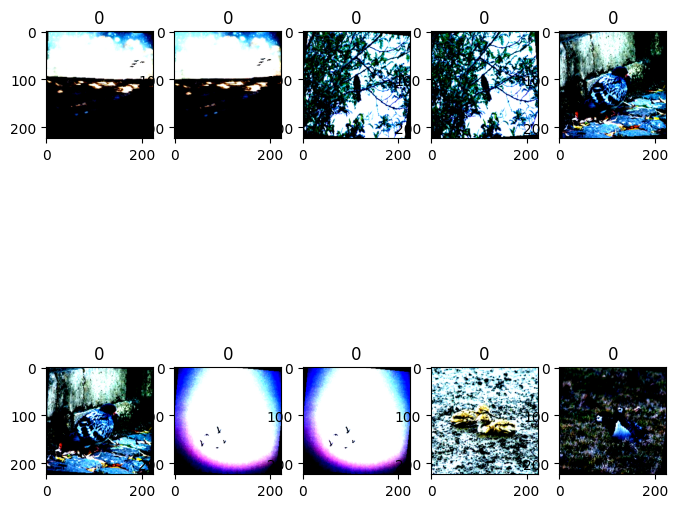

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))

for i in range(10):
     img, label = train_ds[i]
     plt.subplot(2, 5, i + 1)
     plt.imshow(img.permute(1, 2, 0))
     plt.title(label)
plt.show()



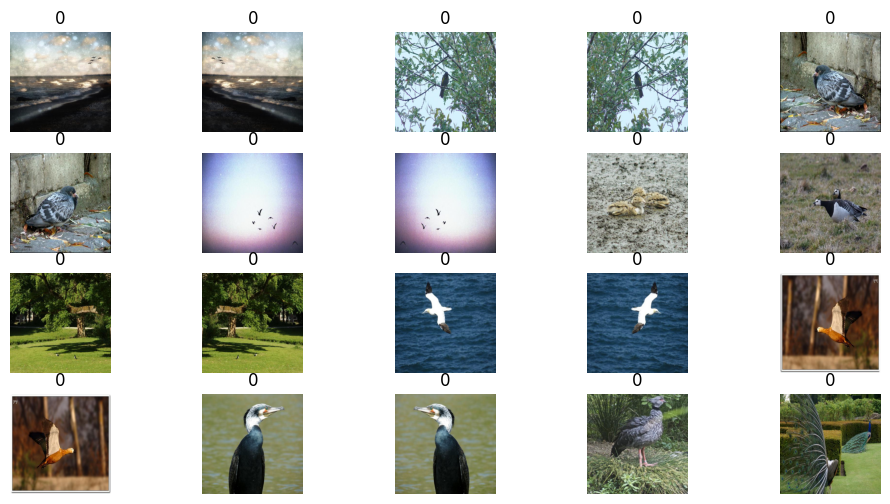

In [23]:
raw_ds = ImageFolder("../data/classification_dataset/train", transform=T.ToTensor())
plt.figure(figsize=(12, 6))

for i in range(20):
     plt.subplot(4, 5, i + 1)
     img, label = raw_ds[i]
     plt.imshow(img.permute(1, 2, 0))
     plt.title(label)
     plt.axis("off")
plt.show()

In [25]:
from collections import Counter

def count_classes(ds):
    labels = [label for _, label in ds]
    return Counter(labels)

print("Train:", count_classes(train_ds))
print("Val:", count_classes(val_ds))
print("Test:", count_classes(test_ds))

print("Classes:", train_ds.classes)


Train: Counter({0: 1414, 1: 1248})
Val: Counter({1: 225, 0: 217})
Test: Counter({0: 121, 1: 94})
Classes: ['bird', 'drone']


In [26]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])


Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1])


In [27]:
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)
print("Labels:", labels[:10])


Images shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 0])


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


In [29]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # 2 classes: Bird, Drone
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using: cuda


In [31]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_acc.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc={train_accuracy:.4f}, Val Acc={val_acc[-1]:.4f}")


Epoch [1/10]: 100%|██████████| 84/84 [00:30<00:00,  2.77it/s]


Epoch 1: Train Acc=0.7006, Val Acc=0.7738


Epoch [2/10]: 100%|██████████| 84/84 [00:25<00:00,  3.29it/s]


Epoch 2: Train Acc=0.7975, Val Acc=0.8009


Epoch [3/10]: 100%|██████████| 84/84 [00:24<00:00,  3.38it/s]


Epoch 3: Train Acc=0.8242, Val Acc=0.8258


Epoch [4/10]: 100%|██████████| 84/84 [00:24<00:00,  3.36it/s]


Epoch 4: Train Acc=0.8373, Val Acc=0.8439


Epoch [5/10]: 100%|██████████| 84/84 [00:24<00:00,  3.37it/s]


Epoch 5: Train Acc=0.8546, Val Acc=0.8235


Epoch [6/10]: 100%|██████████| 84/84 [00:25<00:00,  3.30it/s]


Epoch 6: Train Acc=0.8636, Val Acc=0.8371


Epoch [7/10]: 100%|██████████| 84/84 [00:25<00:00,  3.25it/s]


Epoch 7: Train Acc=0.8745, Val Acc=0.8416


Epoch [8/10]: 100%|██████████| 84/84 [00:24<00:00,  3.38it/s]


Epoch 8: Train Acc=0.9035, Val Acc=0.8439


Epoch [9/10]: 100%|██████████| 84/84 [00:26<00:00,  3.20it/s]


Epoch 9: Train Acc=0.9050, Val Acc=0.8100


Epoch [10/10]: 100%|██████████| 84/84 [00:24<00:00,  3.37it/s]


Epoch 10: Train Acc=0.9020, Val Acc=0.8462


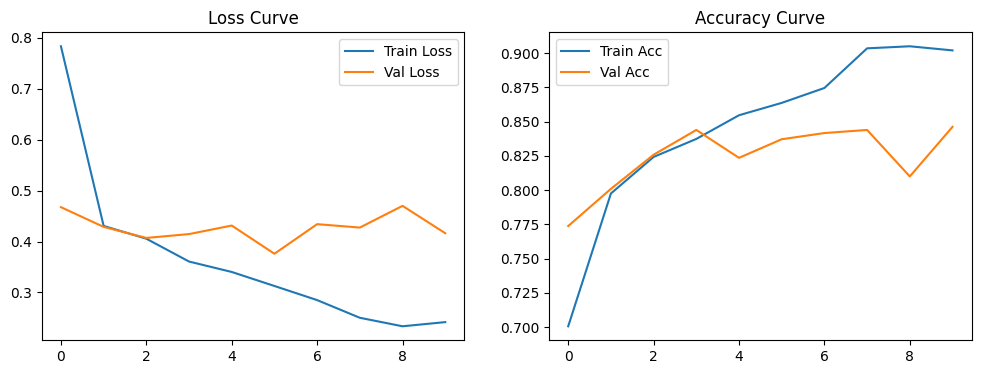

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [34]:
torch.save(model.state_dict(), "../models/custom_cnn.pt")
print("Model saved as custom_cnn.pt")


Model saved as custom_cnn.pt


In [35]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")


Test Accuracy: 0.8884
